Decision Trees using the Titanic Dataset

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.model_selection import learning_curve
import joblib


from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, auc

### Load the Dataset

In [32]:
# Load the dataset
df = pd.read_csv(r'D:\lums\work stuff\notebooks\Week 2\Titanic\train.csv')

# print(df.describe())
print(df.info())
print(df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                      

### Prepare the data

- Cleaning data
- Checking null 
- Drop non useful columns


In [33]:
# Fill in missing values early if needed
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Create engineered features
df['Sex'] = df['Sex'].map({'male' : 0, 'female' : 1})
df = pd.get_dummies(df, columns=['Embarked'])

df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                   'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                   'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df = pd.get_dummies(df, columns=['Title'])

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Drop unused columns
df.drop(['Cabin', 'Ticket', 'Name', 'PassengerId', 'SibSp', 'Parch', 'Embarked_Q'], axis=1, inplace=True)

C:\Users\momin\AppData\Local\Temp\ipykernel_9736\1079982272.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\momin\AppData\Local\Temp\ipykernel_9736\1079982272.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

### Visualising the Dataset 

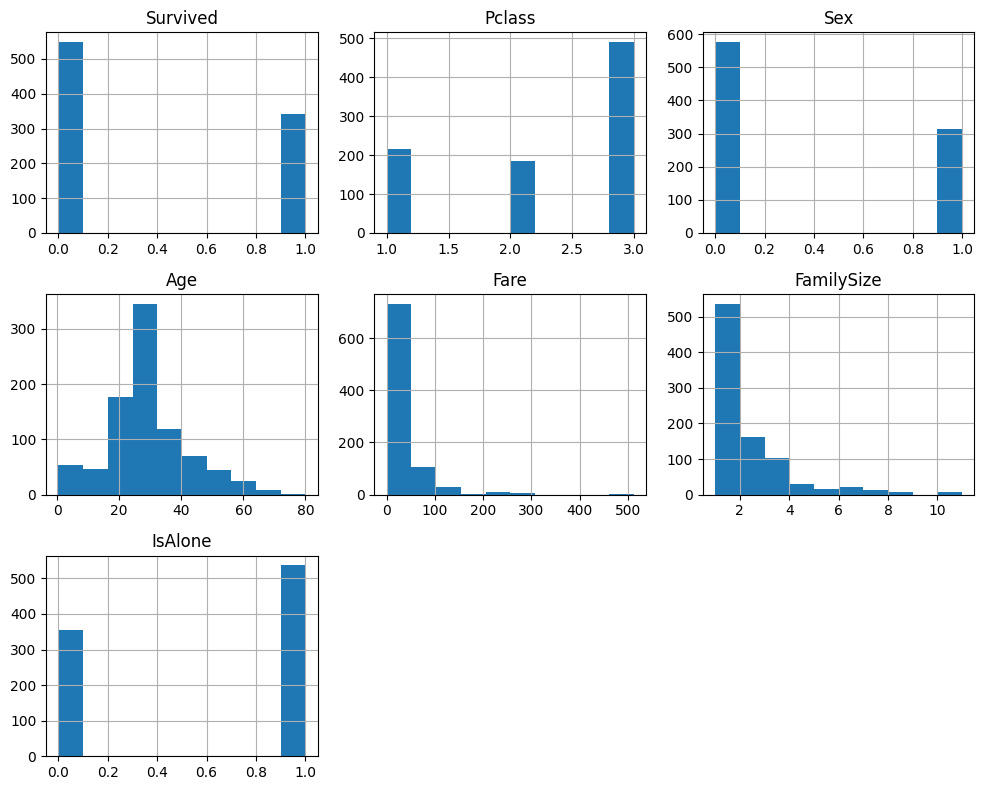

In [34]:
df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()


### Split the data 

In [48]:
X = df.drop('Survived', axis=1)
print(X.columns)
y = df['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# print(X)

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked_C', 'Embarked_S',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
       'FamilySize', 'IsAlone'],
      dtype='object')


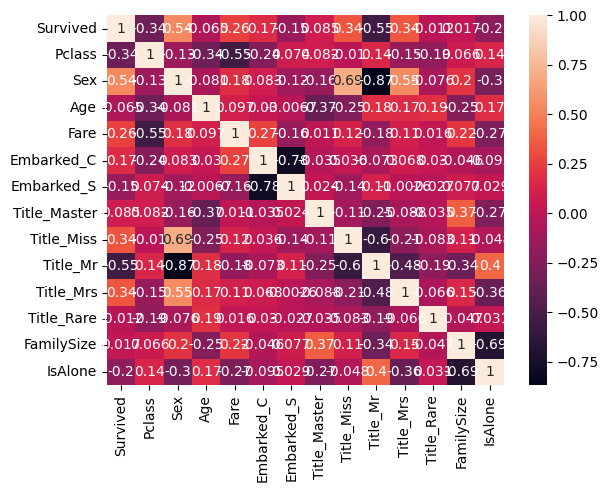

Survived        1.000000
Sex             0.543351
Title_Mrs       0.341994
Title_Miss      0.335636
Fare            0.257307
Embarked_C      0.168240
Title_Master    0.085221
FamilySize      0.016639
Title_Rare     -0.012054
Age            -0.064910
Embarked_S     -0.149683
IsAlone        -0.203367
Pclass         -0.338481
Title_Mr       -0.549199
Name: Survived, dtype: float64


In [36]:
sns.heatmap(df.corr(), annot=True)
plt.show()

correlations = df.corr()['Survived'].sort_values(ascending=False)
print(correlations)

### Preprocessing 

In [37]:
numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'IsAlone'] + \
    [col for col in df.columns if col.startswith('Embarked_') or col.startswith('Title_')]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [49]:
print(X)

     Pclass  Sex   Age     Fare  Embarked_C  Embarked_S  Title_Master  \
0         3    0  22.0   7.2500       False        True         False   
1         1    1  38.0  71.2833        True       False         False   
2         3    1  26.0   7.9250       False        True         False   
3         1    1  35.0  53.1000       False        True         False   
4         3    0  35.0   8.0500       False        True         False   
..      ...  ...   ...      ...         ...         ...           ...   
886       2    0  27.0  13.0000       False        True         False   
887       1    1  19.0  30.0000       False        True         False   
888       3    1  28.0  23.4500       False        True         False   
889       1    0  26.0  30.0000        True       False         False   
890       3    0  32.0   7.7500       False       False         False   

     Title_Miss  Title_Mr  Title_Mrs  Title_Rare  FamilySize  IsAlone  
0         False      True      False       False   

In [38]:
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=3, min_samples_split=2, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(var_smoothing=1e-11)
}


### Grid Search

In [ ]:
# Implementing Grid Search for hyperparameter tuning

model_params = {
    'Decision Tree' : {
        'model' : DecisionTreeClassifier(random_state=42),
        'params' : {
            'classifier__max_depth' : [3,5,7,None],
            'classifier__min_samples_split' : [2,5,10]
        }
    },
    'kNN' : {
        'model' : KNeighborsClassifier(),
        'params' : {
            'classifier__n_neighbors' : list(range(1, 17)),
            'classifier__weights' : ['uniform', 'distance'],
            'classifier__p' : [1, 2, 3]
        }
    },
    'Naive Bayes' : {
        'model' : GaussianNB(),
        'params' : {
            'classifier__var_smoothing' : [1e-9, 1e-10, 1e-11]
        }
    }
}

# Run grid search for each model
for name, mp in model_params.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', mp['model'])
    ])
    grid = GridSearchCV(pipe, mp['params'], cv=5)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # Save the best pipeline for this model
    joblib.dump(best_model, f"titanic_{name.replace(' ', '_').lower()}.joblib")
    
    print(f"🔍 {name} Results")
    print("Best CV Accuracy:", grid.best_score_)
    print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
    print("Best Params:", grid.best_params_)
    print("-" * 50)


🔍 Decision Tree Results
Best CV Accuracy: 0.8161331626120358
Test Set Accuracy: 0.8324022346368715
Best Params: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
--------------------------------------------------
🔍 kNN Results
Best CV Accuracy: 0.83430513148823
Test Set Accuracy: 0.8156424581005587
Best Params: {'classifier__n_neighbors': 16, 'classifier__p': 1, 'classifier__weights': 'uniform'}
--------------------------------------------------
🔍 Naive Bayes Results
Best CV Accuracy: 0.7851669457303261
Test Set Accuracy: 0.7821229050279329
Best Params: {'classifier__var_smoothing': 1e-09}
--------------------------------------------------


### Visualization 

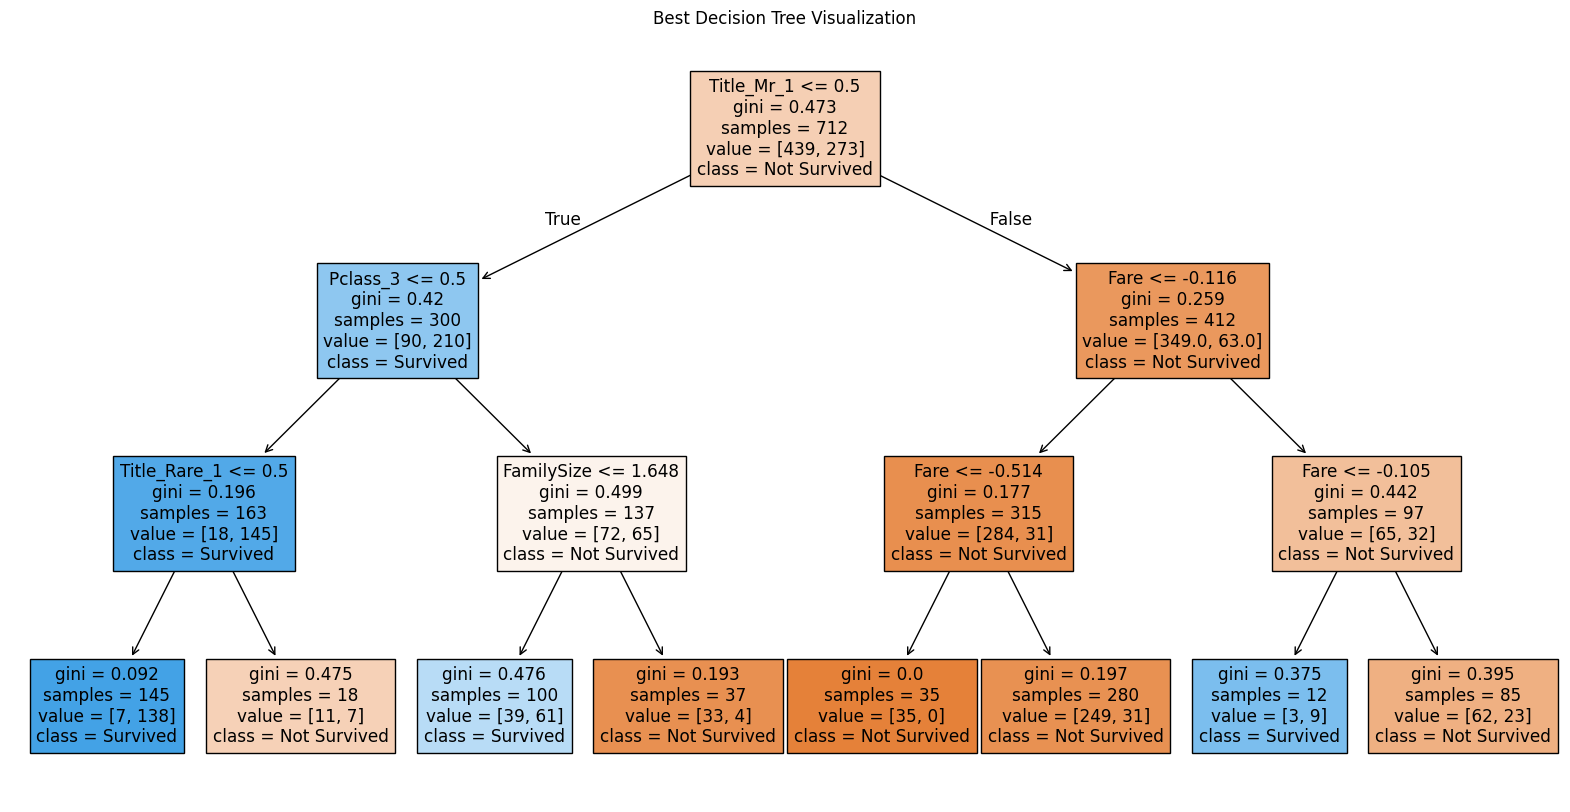

In [40]:
# Fit the pipeline with the best parameters from grid search
dt_grid = GridSearchCV(
    Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))]),
    model_params['Decision Tree']['params'], cv=5
)
dt_grid.fit(X_train, y_train)
best_pipe = dt_grid.best_estimator_
best_tree = best_pipe.named_steps['classifier']

# Get feature names after preprocessing
feature_names = []
# Numeric features
feature_names += best_pipe.named_steps['preprocessor'].transformers_[0][2]
# OneHotEncoder features
ohe = best_pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
cat_features = best_pipe.named_steps['preprocessor'].transformers_[1][2]
feature_names += list(ohe.get_feature_names_out(cat_features))

plt.figure(figsize=(20,10))
tree.plot_tree(best_tree, feature_names=feature_names, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Best Decision Tree Visualization")
plt.show()

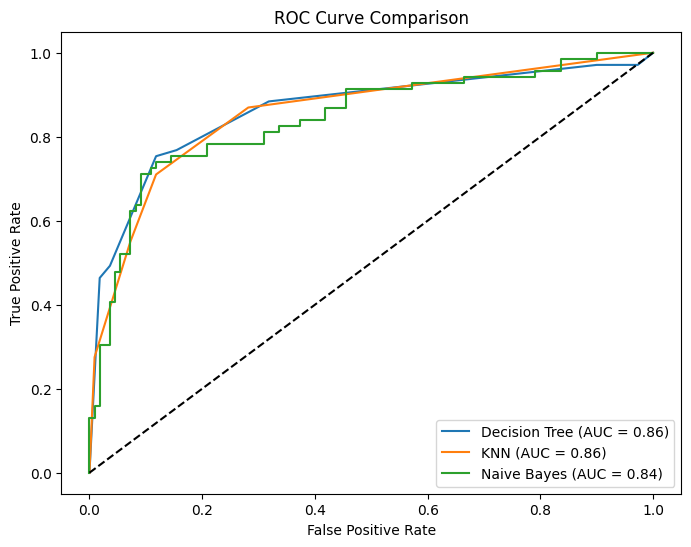

In [41]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    if hasattr(pipe.named_steps['classifier'], "predict_proba"):
        y_score = pipe.predict_proba(X_test)[:,1]
    else:
        continue  # Skip if model doesn't support probability
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

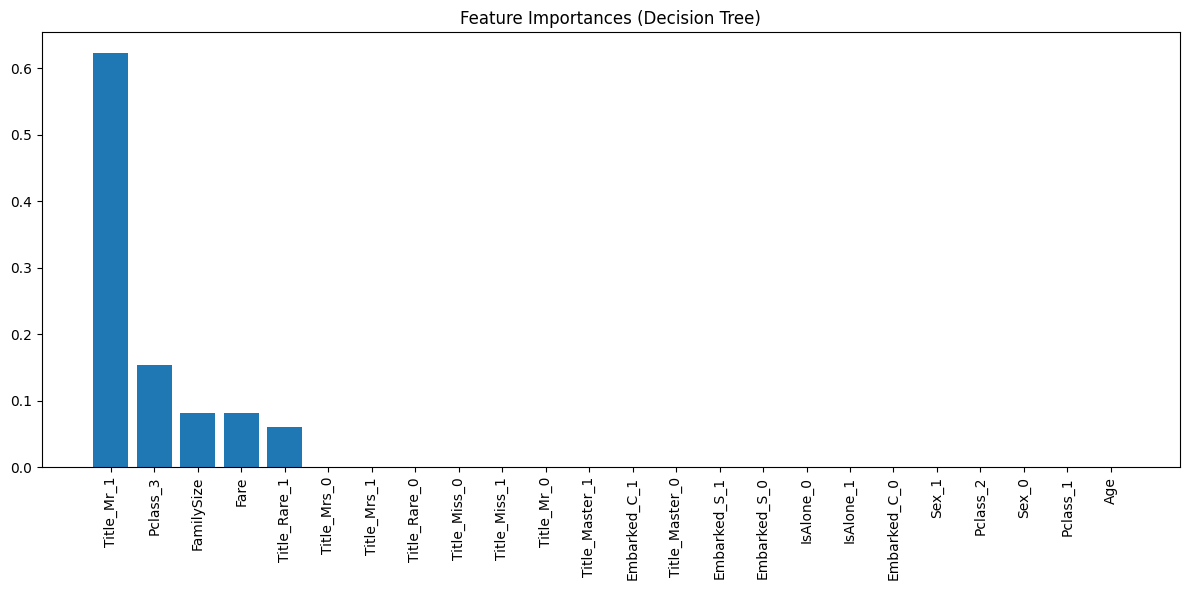

In [42]:
importances = best_tree.feature_importances_
indices = np.argsort(importances)[::-1]

# Use the feature names after preprocessing
plt.figure(figsize=(12,6))
plt.title("Feature Importances (Decision Tree)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.tight_layout()
plt.show()

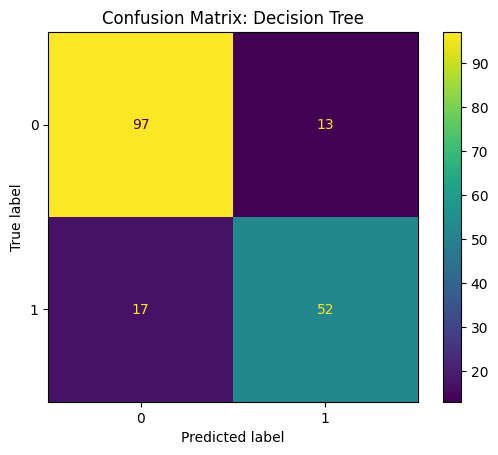

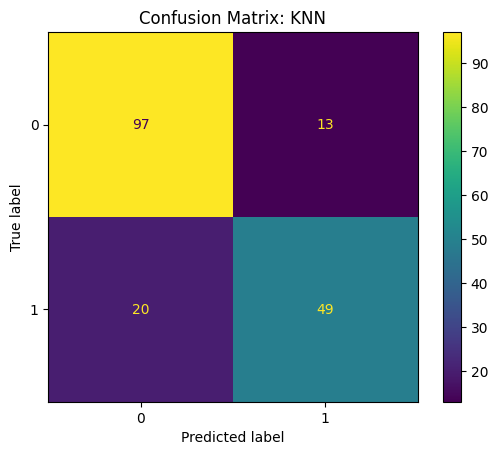

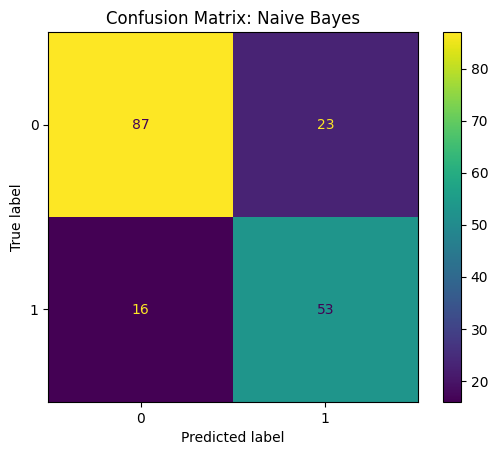

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

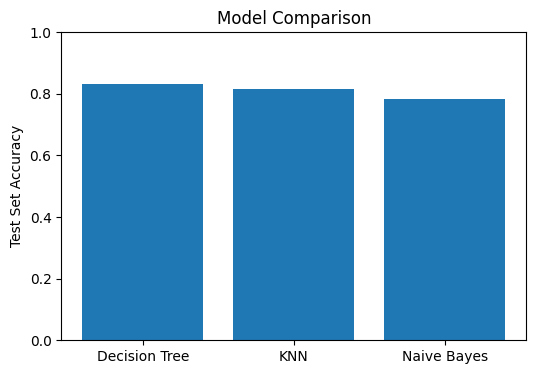

In [44]:
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))

plt.figure(figsize=(6,4))
plt.bar([x[0] for x in results], [x[1] for x in results])
plt.ylabel('Test Set Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()

### Performance Comparison Summary

- **Decision Tree:** Highest test accuracy and good balance between precision and recall. Performs well with engineered features.
- **kNN:** Slightly lower accuracy than Decision Tree, but competitive. Sensitive to feature scaling and hyperparameters.
- **Naive Bayes:** Performs reasonably well, but generally lower than the other two. Assumes feature independence.

**Overall:**  
Decision Tree and kNN perform best on this dataset. Feature engineering and hyperparameter tuning further improve results. Confusion matrices show that all models have some difficulty with minority class prediction, but overall performance is strong.